In [1]:
import os
import urllib.request

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
from rasterio.warp import transform
import pandas as pd
import xarray as xr

In [41]:
# ref = xr.open_rasterio('../../../data_general/proc_sif-optim/sif_refgrid.tif')
# ref = ref.rename("SIF")
# ref.to_netcdf(path='../../../data_general/proc_sif-optim/covar_nc/sif_refgrid.nc',
#              mode='w',
#             format='NETCDF4', 
#             encoding={"SIF":{"zlib":True}} )
ref = xr.open_dataset("../../../data_general/proc_sif-optim/covar_nc/sif_refgrid.nc")
ref = ref['SIF']
ref = ref.rename({"lon":"x",
           "lat":"y"})

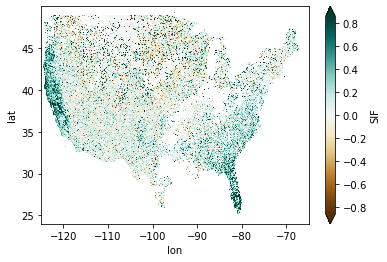

In [7]:

ref.plot(cmap = plt.cm.BrBG, # color palette
         robust=True, # color bar limits to 2-98%
    cbar_kwargs={})

AttributeError: module 'cartopy.crs' has no attribute 'is_geodetic'

In [10]:
# get projection 


ModuleNotFoundError: No module named 'pyepsg'

In [35]:
da = xr.open_rasterio('../../../data_general/proc_sif-optim/myd11a1_2018-0000000000-0000000000.tif')
da

<xarray.DataArray (band: 364, y: 1280, x: 1280)>
[596377600 values with dtype=float64]
Coordinates:
  * band     (band) int64 1 2 3 4 5 6 7 8 9 ... 357 358 359 360 361 362 363 364
  * y        (y) float64 49.38 49.38 49.37 49.36 49.35 ... 37.92 37.91 37.9 37.9
  * x        (x) float64 -124.7 -124.7 -124.7 -124.7 ... -113.3 -113.3 -113.2
Attributes:
    transform:      (0.008983152841195215, 0.0, -124.74006035283676, 0.0, -0....
    crs:            +init=epsg:4326
    res:            (0.008983152841195215, 0.008983152841195215)
    is_tiled:       1
    nodatavals:     (nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, n...
    scales:         (1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1...
    offsets:        (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...
    AREA_OR_POINT:  Area

In [19]:
np.diff(ref['lon'])

array([0.0045, 0.0045, 0.0045, ..., 0.0045, 0.0045, 0.0045])

In [17]:
np.diff(da['x'])

array([0.00898315, 0.00898315, 0.00898315, ..., 0.00898315, 0.00898315,
       0.00898315])

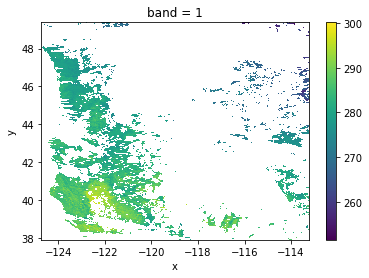

In [15]:
da[0,:,:].plot()

In [36]:
test = da[0,:,:].interp_like(ref,method='nearest')

In [42]:
ref['x']

<xarray.DataArray 'x' (x: 13334)>
array([-125.    , -124.9955, -124.991 , ...,  -65.0105,  -65.006 ,  -65.0015])
Coordinates:
  * x        (x) float64 -125.0 -125.0 -125.0 -125.0 ... -65.01 -65.01 -65.0
Attributes:
    Unit:     degrees

In [46]:
test = da.interp(x=ref['x'], y=ref['y'],method='nearest')

MemoryError: Unable to allocate 209. GiB for an array with shape (5778, 4853576) and data type float64

In [44]:
test.shape

(5778, 13334)

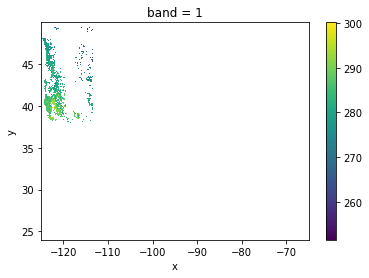

In [45]:
test.plot()

<xarray.DataArray 'SIF' (lat: 5778, x: 13334)>
[77043852 values with dtype=float32]
Coordinates:
  * x        (x) float64 -125.0 -125.0 -125.0 -125.0 ... -65.01 -65.01 -65.0
  * lat      (lat) float64 24.0 24.0 24.01 24.01 ... 49.98 49.99 49.99 50.0
Attributes:
    Unit:     mW/m^2/sr/nm

In [66]:
# Compute the lon/lat coordinates with rasterio.warp.transform
ny, nx = len(da['y']), len(da['x'])
x, y = np.meshgrid(da['x'], da['y'])

# Rasterio works with 1D arrays
lon, lat = transform(da.crs, {'init': 'EPSG:4326'},
                     x.flatten(), y.flatten())
lon = np.asarray(lon).reshape((ny, nx))
lat = np.asarray(lat).reshape((ny, nx))
da.coords['lon'] = (('y', 'x'), lon)
da.coords['lat'] = (('y', 'x'), lat)

In [67]:
da = da.rename({'band':'time'})

In [68]:
da = da.rename("lst")

In [70]:
da.coords['time'] = pd.date_range("2018-01-01", periods=364)

In [72]:
da.to_netcdf(path='../../../data_general/proc_sif-optim/covar_nc/myd11a1_2018-0000000000-0000000000.nc',
             mode='w',
            format='NETCDF4', 
            encoding={"lst":{"zlib":True, "complevel":9}} )

In [31]:
i1 = da[1:3,:,:]

In [40]:
i2 = i1.mean(dim=1:2)
i2.plot()

SyntaxError: invalid syntax (<ipython-input-40-12ecb3c68009>, line 1)

In [10]:
tmp1 = i1.to_dataframe(name='lst')

In [13]:
tmp1 = tmp1.dropna()
tmp1

band         lon        lat     lst
y         x                                               
49.384883 -115.950045     2 -115.950045  49.384883  256.24
          -115.743433     2 -115.743433  49.384883  258.46
          -115.734450     2 -115.734450  49.384883  260.90
          -115.725466     2 -115.725466  49.384883  260.90
          -115.716483     2 -115.716483  49.384883  261.78
...                     ...         ...        ...     ...
39.215954 -121.187223     2 -121.187223  39.215954  286.64
          -121.178240     2 -121.178240  39.215954  287.46
          -120.872813     2 -120.872813  39.215954  287.02
          -120.863830     2 -120.863830  39.215954  287.66
          -120.854847     2 -120.854847  39.215954  287.66

[232969 rows x 4 columns]

/home/sami/miniconda3/envs/sci/lib/python3.7/site-packages/cartopy/io/__init__.py:260: DownloadWarning: Downloading: http://naciscdn.org/naturalearth/10m/physical/ne_10m_coastline.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


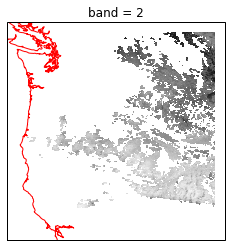

In [21]:
# Plot on a map
ax = plt.subplot(projection=ccrs.PlateCarree())
i1.plot(ax=ax, x='lon', y='lat', transform=ccrs.PlateCarree(),
               cmap='Greys_r', add_colorbar=False)
ax.coastlines('10m', color='r')
plt.show()

<bound method DataArray.to_dataframe of <xarray.DataArray (y: 1280, x: 1280)>
[1638400 values with dtype=float64]
Coordinates:
    band     int64 2
  * y        (y) float64 49.38 49.38 49.37 49.36 49.35 ... 37.92 37.91 37.9 37.9
  * x        (x) float64 -124.7 -124.7 -124.7 -124.7 ... -113.3 -113.3 -113.2
    lon      (y, x) float64 -124.7 -124.7 -124.7 -124.7 ... -113.3 -113.3 -113.2
    lat      (y, x) float64 49.38 49.38 49.38 49.38 ... 37.9 37.9 37.9 37.9
Attributes:
    transform:      (0.008983152841195215, 0.0, -124.74006035283676, 0.0, -0....
    crs:            +init=epsg:4326
    res:            (0.008983152841195215, 0.008983152841195215)
    is_tiled:       1
    nodatavals:     (nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, n...
    scales:         (1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1...
    offsets:        (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...
    AREA_OR_POINT:  Area>